In [1]:
import numpy as np
from sklearn.utils.extmath import randomized_svd
from time import time
from matplotlib import pyplot as plt
import scipy.sparse as sp
import time
def generate_3d_grid_matrix(k):
    size = 2**(3*k)
    grid_size = 2**k

    matrix = sp.lil_matrix((size, size), dtype=float)

    for i in range(grid_size):
        for j in range(grid_size):
            for l in range(grid_size):
                current_vertex = i * grid_size**2 + j * grid_size + l

                for di, dj, dl in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                    ni, nj, nl = i + di, j + dj, l + dl

                    if 0 <= ni < grid_size and 0 <= nj < grid_size and 0 <= nl < grid_size:
                        neighbor_vertex = ni * grid_size**2 + nj * grid_size + nl

                        matrix[current_vertex, neighbor_vertex] = np.random.rand()

    return matrix

In [2]:
def is_admissible(matrix, S, r, eps):
    if min(matrix.shape) <= r:
        return True
    
    if S[-1] < eps:
        return True
    
    return False     

In [3]:
class Node:
    def __init__(self, t_min, t_max, s_min, s_max):
        self.t_min = t_min
        self.t_max = t_max
        
        self.s_min = s_min
        self.s_max = s_max
        
        self.rank = None # = 0 ---> zero matrix, #None ---> not a leaf
        
        self.U = None
        self.S = None
        self.V = None

        self.tag = ""
        
        
        self.children = []

In [4]:
def create_tree(matrix, r, eps):
    n, m = matrix.shape

    
    def create_tree_r(t_min, t_max, s_min, s_max):
        nonlocal matrix, r, eps
        
        if not np.any(matrix[t_min:t_max, s_min:s_max]):
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
    
        U,S,V = randomized_svd(matrix[t_min:t_max, s_min:s_max], r)
        
        S = S[S >= eps]  
        rank = len(S)
        
        U = U[:, :rank]
        V = V[:rank, :]
        if rank == 0:
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
        
        
        if is_admissible(matrix[t_min:t_max, s_min:s_max], S, r, eps):
            v = Node(t_min, t_max, s_min, s_max) #compress matrix
            v.rank = rank
            v.U = U
            v.S = S
            v.V = V
            return v
            
        else:
            v = Node(t_min, t_max, s_min, s_max)
            
            t_newmax = (t_min + t_max)//2
            s_newmax = (s_min + s_max)//2
            
            v1 = create_tree_r(t_min, t_newmax, s_min, s_newmax)
            v2 = create_tree_r(t_min, t_newmax, s_newmax, s_max)
            v3 = create_tree_r(t_newmax, t_max, s_min, s_newmax)
            v4 = create_tree_r(t_newmax, t_max, s_newmax, s_max)
            
            v.children = [v1, v2, v3, v4]
        return v
    return create_tree_r(0, n, 0, m)



In [5]:
def decompress(node):
    if node.rank is not None:
        if node.rank > 0:
            return node.U@np.diag(node.S)@node.V
        else:
            return np.zeros((node.t_max - node.t_min, node.s_max - node.s_min))
    else:
        return np.vstack(
            (
                np.hstack((decompress(node.children[0]), decompress(node.children[1]))),
                np.hstack((decompress(node.children[2]), decompress(node.children[3]))),
            )
        )   

In [6]:
def error(tree, matrix):
    return np.sum(np.square(matrix - decompress(tree)))

In [7]:
def plot_matrix(root, matrix, singular_values = None, title = None):
    size = matrix.shape
    tmap = np.zeros(size)
    
    def fill_map(node):
        nonlocal tmap
        if node.rank is not None:
            if node.rank != 0:
                tmap[node.t_min:node.t_max, node.s_min:node.s_min + node.rank] = 1
                tmap[node.t_min:node.t_min + node.rank, node.s_min:node.s_max] = 1
        else:
            for submatrix in node.children:
                fill_map(submatrix)
    fill_map(root)

    if singular_values is not None:
        f, ax = plt.subplots(2,1)
        ax[0].spy(tmap)
        if title is not None:
            ax[0].set_title(title)
        x = np.array([i for i in range(len(singular_values))])
        ax[1].scatter(x, singular_values)
    else:
        f, ax = plt.subplots(1,1)
        ax.spy(tmap)
        if title is not None:
            ax.set_title(title)

[[0.         0.68944777 0.         ... 0.         0.         0.        ]
 [0.06839607 0.         0.90437983 ... 0.         0.         0.        ]
 [0.         0.50107701 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.127342   0.        ]
 [0.         0.         0.         ... 0.08575202 0.         0.22554707]
 [0.         0.         0.         ... 0.         0.94530514 0.        ]]


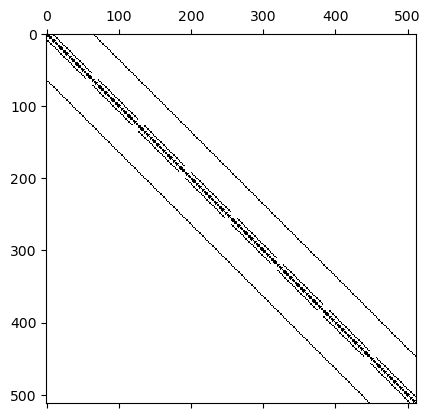

In [8]:
p = generate_3d_grid_matrix(3).toarray()
print(p)
tree = create_tree(p, 2, 10**(-8))
plot_matrix(tree, p)

In [17]:
def matrix_vector_mult(v, X):
    if len(v.children) == 0:
        if v.rank == 0:
            return np.zeros_like(X)
        return v.U@(v.V@X)
    else:
        n = X.shape[0]
    
        X1, X2 = X[:n//2], X[n//2:]
        Y11 = matrix_vector_mult(v.children[0], X1)
        Y12 = matrix_vector_mult(v.children[1], X2)
        Y21 = matrix_vector_mult(v.children[2], X1)
        Y22 = matrix_vector_mult(v.children[3], X2)

        return np.vstack((Y11 + Y12, Y21 + Y22))

In [10]:
def matrix_matrix_add(v, w):
    ret = Node(v.t_min, v.t_max, v.s_min, v.s_max)
    
    if len(v.children) == 0 and len(w.children) == 0 and (v.rank == 0 or w.rank == 0):
        ret.rank = 0
        ret.U = v.U
        ret.V = v.V
        ret.S = v.S
        return ret
    if len(v.children) == 0 and len(w.children) == 0 and v.rank != 0 and w.rank != 0:
        ustack = np.concatenate((v.U, w.U), axis = 1)
        vstack = np.concatenate((v.V, w.V), axis = 0)
        temp = ustack@vstack
        r = max(v.rank, w.rank)
        U, S, V = randomized_svd(temp, r)
        ret.U = U
        ret.S = S
        ret.V = V
        ret.rank = r
        ret.children = []
        
        return ret


    
    if len(v.children) > 0 and len(w.children) > 0:
        R11 = matrix_matrix_add(v.children[0], w.children[0])
        R12 = matrix_matrix_add(v.children[1], w.children[1])
        R21 = matrix_matrix_add(v.children[2], w.children[2])
        R22 = matrix_matrix_add(v.children[3], w.children[3])
        ret.children =  [R11, R12, R21, R22]
        return ret
    elif len(v.children) == 0 or len(w.children) == 0:
        leaf = w if len(v.children) != 0 else v
        other = w if len(v.children) == 0 else v

        n = leaf.U.shape[0]//2
        m = leaf.V.shape[1]//2
        u11, u12 = leaf.U[:n, :],leaf.U[n:, :]
        v11, v12 = leaf.V[:, :m], leaf.V[:, m:]
        
        t_min = other.t_min
        t_max = other.t_max
        s_min = other.s_min
        s_max = other.s_max
        
        t_newmax = (t_min + t_max)//2
        s_newmax = (s_min + s_max)//2

        v1 = Node(t_min, t_newmax, s_min, s_newmax)
        v1.U = u11
        v1.V = v11
        v1.rank = max(n,m)
        v1.tag = "v1"
        
        v2 = Node(t_min, t_newmax, s_newmax, s_max)
        v2.U = u11
        v2.V = v12
        v2.rank = max(n,m)
        v2.tag = "v2"
        
        v3 = Node(t_newmax, t_max, s_min, s_newmax)
        v3.U = u12
        v3.V = v11
        v3.rank = max(n,m)
        v3.tag = "v3"
        
        v4 = Node(t_newmax, t_max, s_newmax, s_max)
        v4.U = u12
        v4.V = v12
        v4.rank = max(n,m)
        v4.tag = "v4"

        R11 = matrix_matrix_add(v1, other.children[0])
        R12 = matrix_matrix_add(v2, other.children[1])
        R21 = matrix_matrix_add(v3, other.children[2])
        R22 = matrix_matrix_add(v4, other.children[3])
        ret.children =  [R11, R12, R21, R22]
        return ret
    print("outofifadd")

In [11]:
def matrix_matrix_mult(v, w):
    ret = Node(v.t_min, v.t_max, v.s_min, v.s_max)
    if len(v.children) == 0 and len(w.children) == 0:
        if v.rank == 0 or w.rank == 0:
            ret.rank = 0
            ret.U = v.U
            ret.V = v.V
            ret.S = v.S
            return ret
        elif v.rank != 0 and w.rank != 0:
            # print("V",v.U, v.V, v.rank, len(v.children), v.tag)
            # print("U", w.U, w.V, w.rank, len(w.children), w.tag)
            temp = v.U@(v.V@w.U)@w.V
            r = max(v.rank, w.rank)
            U, S, V = randomized_svd(temp, r)
            ret.U = U
            ret.S = S
            ret.V = V
            ret.rank = r

            #print("mult:::: \n", ret.U, ret.V, "\n", v.V.shape, v.U.shape, w.V.shape, w.U.shape)
            return ret
    elif len(v.children) > 0 and len(w.children) > 0:
        A1, A2, A3, A4 = v.children[0], v.children[1], v.children[2], v.children[3]
        B1, B2, B3, B4 = w.children[0], w.children[1], w.children[2], w.children[3] 

        r11 = matrix_matrix_add(matrix_matrix_mult(A1, B1), matrix_matrix_mult(A2, B3))
        r12 = matrix_matrix_add(matrix_matrix_mult(A1, B2), matrix_matrix_mult(A2, B4))
        r21 = matrix_matrix_add(matrix_matrix_mult(A3, B1), matrix_matrix_mult(A4, B3))
        r22 = matrix_matrix_add(matrix_matrix_mult(A3, B2), matrix_matrix_mult(A4, B4))
        # for c in [r11,r12,r21,r22]:
        #     print("cccC", c.U, c.V, c.rank, c.children)
        ret.children = [r11,r12,r21,r22]
        return ret
    elif len(v.children) == 0 or len(w.children) == 0:
        #print("lif:", v.children, w.children)
        leaf = w if len(v.children) != 0 else v
        other = w if len(v.children) == 0 else v
        print(leaf.U,leaf.V, leaf.rank)
        B1, B2, B3, B4 = other.children[0], other.children[1], other.children[2], other.children[3] 

        n = leaf.U.shape[0]//2
        m = leaf.V.shape[1]//2
        u11, u12 = leaf.U[:n, :],leaf.U[n:, :]
        v11, v12 = leaf.V[:, :m], leaf.V[:, m:]

        #print("LLLLLLLLLLLLLLL", u11, u12, v11, v12)
        t_min = other.t_min
        t_max = other.t_max
        s_min = other.s_min
        s_max = other.s_max
        
        t_newmax = (t_min + t_max)//2
        s_newmax = (s_min + s_max)//2

        v1 = Node(t_min, t_newmax, s_min, s_newmax)
        v1.U = u11
        v1.V = v11
        v1.rank = min(n,m)
        v1.tag = "v1"
        
        v2 = Node(t_min, t_newmax, s_newmax, s_max)
        v2.U = u11
        v2.V = v12
        v2.rank = min(n,m)
        v2.tag = "v2"
        
        v3 = Node(t_newmax, t_max, s_min, s_newmax)
        v3.U = u12
        v3.V = v11
        v3.rank = min(n,m)
        v3.tag = "v3"
        
        v4 = Node(t_newmax, t_max, s_newmax, s_max)
        v4.U = u12
        v4.V = v12
        v4.rank = min(n,m)
        v4.tag = "v4"

        R11 = matrix_matrix_add(matrix_matrix_mult(v1, B1), matrix_matrix_mult(v2,B3))
        R12 = matrix_matrix_add(matrix_matrix_mult(v1, B2), matrix_matrix_mult(v2,B4))
        R21 = matrix_matrix_add(matrix_matrix_mult(v3, B1), matrix_matrix_mult(v4,B3))
        R22 = matrix_matrix_add(matrix_matrix_mult(v3, B2), matrix_matrix_mult(v4,B4))
        ret.children =  [R11, R12, R21, R22]
        return ret
    print("outofifmult")
        
            
        

In [12]:
print(p.shape)

(512, 512)


In [13]:
X = np.random.random((512,1))

In [14]:
c = matrix_vector_mult(tree, X)

None
None
None
None
None
None
None
None
[[0. 1.]
 [1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]
 [0. 1.]]
None
None
None
[[1. 0.]]
None
None
None
[[0. 1.]]
None
None
None
[[1. 0.]
 [0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]
 [0. 1.]]
None
None
[[1. 0.]
 [0. 1.]]
None
None
[[0. 1.]
 [1. 0.]]
None
None
None
[[0. 1.]
 [1. 0.]]
None
None
[[0. 1.]
 [1. 0.]]
None
None
[[0. 1.]
 [1. 0.]]
None
None
[[1. 0.]
 [0. 1.]]
None
None
None
[[0. 1.]
 [1. 0.]]
None
None
[[1. 0.]
 [0. 1.]]
None
None
[[1. 0.]
 [0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]
 [0. 1.]]
None
None
None
[[1. 0.]]
None
None
None
[[0. 1.]]
None
None
None
[[0. 1.]
 [1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]
 [1. 0.]]
None
None
None
None
None
[[0. 1.]
 [1. 0.]]
None
None
[[0. 1.]
 [1. 0.]]
None
None
None
[[1. 0.]
 [0. 1.]]
None
None
[[0. 1.]
 [1. 0.]]
None
None
None
None
None
[[1. 0.]
 [0. 1.]]
None
None
[[0. 1.]
 [1. 0.]]
None
None
None
[[1. 0.]
 [0. 1.]]
None
None
[[1. 0.]
 [0. 1.]]
None
None
None
None
None
[[0. 1.]
 [1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]
 

In [15]:
p1 = generate_3d_grid_matrix(3)
tree1 = create_tree(p1, 4, 10**(-8))
plot_matrix(tree1, p1)

NameError: name 'generate_3d_matrix' is not defined

In [ ]:
rr = matrix_matrix_add(tree, tree)
rrm = decompress(rr)

In [ ]:
plot_matrix(rr, rrm)

2.943290365945425
94.62147499133195
653.1757288782699
5636.8005245898175
44917.21136917699


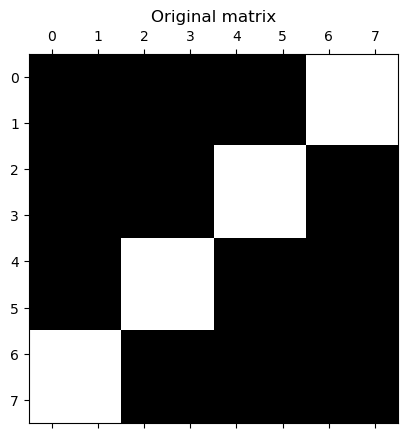

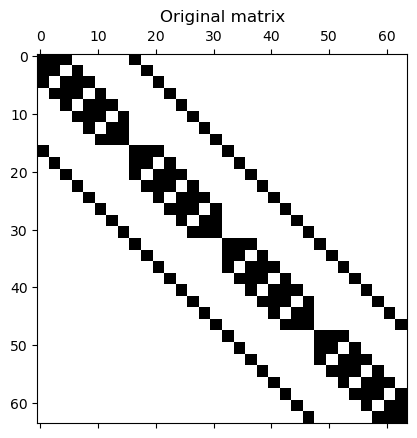

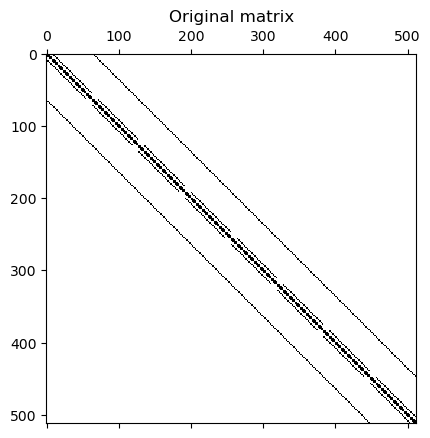

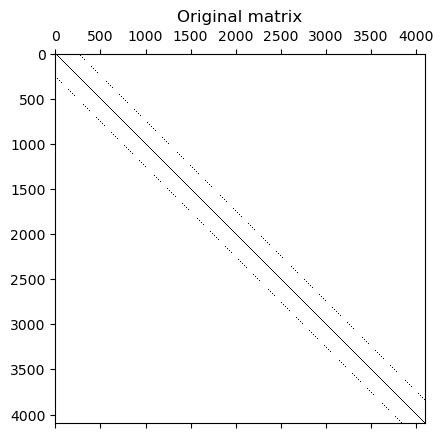

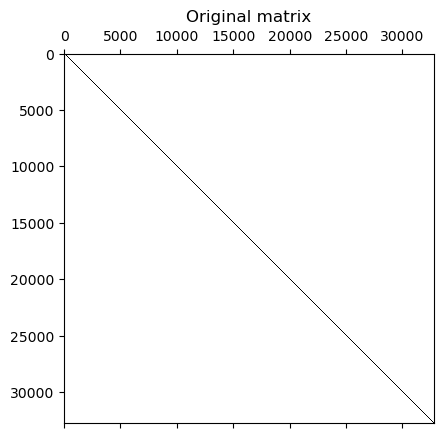

In [28]:
sizes = [i for i in range(1,6)]

results = []

for size in sizes:
    matrix = generate_3d_grid_matrix(size)
    matrix = matrix.toarray()

    tree = create_tree(matrix, 2, -1)
    plot_matrix(tree, matrix, title = "Original matrix")

    s = 2**(3*size)
    vector = np.random.random((s, 1))

    start = time.time()
    r1 = matrix_vector_mult(tree, vector)
    end = time.time()
    results.append(end-start)
    decompressed = decompress(tree)
    r2 = decompressed@vector

    error = np.sum(np.square(r1 - r2))
    print(error)

In [29]:
from scipy.optimize import curve_fit

In [30]:
def func(x, a, b):
    return a * np.power(x,b)

In [31]:
sizes = np.array(sizes)
results = np.array(results)
sizes = 2**(3*sizes)

In [32]:
params_std, cov_std = curve_fit(func, sizes, results)

In [34]:
print(params_std)

[1.84298665e-05 1.10209887e+00]
